<a href="https://colab.research.google.com/github/ashwani-09/esg_topicmodelling/blob/master/ReutersNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KerasNLP - Reuters
=================
First Iteration
---------------
 1. Build a simple model with entire data from Reuters dataset
 2. Model architechture
  ```
  InputLayer()
  Dense(512, "relu")
  Dropout(0.5)
  Dense(46, "softmax") --> Ouput
  ```
 3. Metrics
  ```
  loss="categorical_crossentropy",
  optimizer="adam",
  metrics=["categorical_accuracy"]
  ```
 4. Result
  ```
  score = (14.71, 0.344)
  ```

Second Iteration
----------------
 1. Pick only 512 most frequent words
 2. Model architechture
  ```
  Model: "sequential"
  _________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 embedding (Embedding)       (None, 512, 512)          262656    
                                                                 
 dropout (Dropout)           (None, 512, 512)          0         
                                                                 
 global_average_pooling1d (G  (None, 512)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 46)                23598     
                                                                 
  =================================================================
 ```
 3. Results
  ```
  score = (1.3, 0.72)
  ```

In [ ]:
import numpy as np
import sys, os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from pprint import pprint
import plotly.graph_objects as go
import matplotlib.pyplot as plt

**Prepare data**
 - Pad unequal sequences
 - Convert labels to one-hot encoded variables for multi-class categorical classification
 - Build an index-word map to obtain original sentences

In [ ]:
word_index = keras.datasets.reuters.get_word_index()

In [ ]:
index_word = {}
for word, index in word_index.items():
  index_word[index] = word

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.reuters.load_data(num_words=512, seed=113)

In [ ]:
training_data_corpus = np.hstack(x_train)
print("Number of unique words in training data: ", len(np.unique(training_data_corpus)))
print("Min index in training data: ", min(training_data_corpus))
print("Max index in training data: ", max(training_data_corpus))

Number of unique words in training data:  510
Min index in training data:  1
Max index in training data:  511


In [ ]:
" ".join([index_word[index] for index in x_train[0] if index != 0])

'the of of mln loss for plc said at only ended said of could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln of an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 of of several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed of april 0 are 2 states will billion total and against 000 pct dlrs'

To remove most frequent and least frequent words from training data, we can simply remove the lowest and highest indices from training data.

In [ ]:
MOST_COMMON_WORDS_TO_REMOVE = 50
MOST_COMMON_WORDS_TO_KEEP = 128
unique_index = np.unique(training_data_corpus)
sorted_unique_index = sorted(unique_index)
keep_index = sorted_unique_index[MOST_COMMON_WORDS_TO_REMOVE:MOST_COMMON_WORDS_TO_KEEP]
print(min(keep_index), max(keep_index))

52 129


In [ ]:
%%time
# x_train = [[index for index in row if index in keep_index] for row in x_train]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.58 µs


In [ ]:
print(x_train[0])

[111, 90, 67, 89, 102, 124, 90, 67, 84, 83, 90, 67, 52, 109]


In [ ]:
def plot_lengths(data):
  data_len = [len(x) for x in data]

  fig = go.Figure(data=[go.Histogram(x=data_len)])
  fig.show()

In [ ]:
plot_lengths(x_train)

In [ ]:
trimmed_data_corpus = np.hstack(x_train)
print("Number of unique words in training data: ", len(np.unique(trimmed_data_corpus)))
print("Min index in training data: ", min(trimmed_data_corpus))
print("Max index in training data: ", max(trimmed_data_corpus))

Number of unique words in training data:  78
Min index in training data:  52.0
Max index in training data:  129.0


In [ ]:
MAXLEN = 512

In [ ]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train, padding='post', maxlen=MAXLEN)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, padding='post', maxlen=MAXLEN)
print(x_train.shape)

(8982, 512)


In [ ]:
NUM_CLASSES = len(np.unique(y_train))
y_train = tf.one_hot(y_train, NUM_CLASSES)
y_test = tf.one_hot(y_test, NUM_CLASSES)
print(y_train.shape)
print(y_test.shape)

(8982, 46)
(2246, 46)


In [ ]:
#Check: test tensor conversion
_ = tf.convert_to_tensor(x_train)
_ = tf.convert_to_tensor(y_train)

Build Model
-----------

**Metrics**
 - BinaryCrossEntropy --> only 0 or 1 labels
 - CategoricalCrossentropy --> multi label classification, tf.one_hot y labels
 - SparseCategoricalCrossentropy --> when passing labels as integers

In [ ]:
keras.backend.clear_session()

model = keras.Sequential()
# model.add(layers.InputLayer(input_shape=(MAXLEN)))
# model.add(layers.Dense(512, activation="relu"))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(NUM_CLASSES, activation="softmax"))

model.add(layers.InputLayer(input_shape=(MAXLEN)))
model.add(layers.Embedding(MAXLEN + 1, MAXLEN))
model.add(layers.Dropout(0.2))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(NUM_CLASSES, activation="softmax"))

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["categorical_accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 512)          262656    
                                                                 
 dropout (Dropout)           (None, 512, 512)          0         
                                                                 
 global_average_pooling1d (G  (None, 512)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 46)                23598     
                                                                 
Total params: 286,254
Trainable params: 286,254
Non-trainable params: 0
__________________________________________________

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((8982, 512), (2246, 512), TensorShape([8982, 46]), TensorShape([2246, 46]))

In [ ]:
%%time
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=10,
    validation_data=(x_test, y_test),
    verbose=1
)

Epoch 1/10
281/281 [==============================] - 38s 133ms/step - loss: 2.4376 - categorical_accuracy: 0.3725 - val_loss: 2.1518 - val_categorical_accuracy: 0.4150
Epoch 2/10
281/281 [==============================] - 38s 135ms/step - loss: 2.0447 - categorical_accuracy: 0.4685 - val_loss: 1.9388 - val_categorical_accuracy: 0.5365
Epoch 3/10
281/281 [==============================] - 37s 132ms/step - loss: 1.8337 - categorical_accuracy: 0.5616 - val_loss: 1.7662 - val_categorical_accuracy: 0.5980
Epoch 4/10
281/281 [==============================] - 42s 151ms/step - loss: 1.6634 - categorical_accuracy: 0.6146 - val_loss: 1.6375 - val_categorical_accuracy: 0.6300
Epoch 5/10
281/281 [==============================] - 40s 143ms/step - loss: 1.5373 - categorical_accuracy: 0.6480 - val_loss: 1.5402 - val_categorical_accuracy: 0.6594
Epoch 6/10
281/281 [==============================] - 37s 132ms/step - loss: 1.4377 - categorical_accuracy: 0.6696 - val_loss: 1.4735 - val_categorical_acc

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Validation loss: ", score[0])
print("Categorical accuracy: ", score[1])

Validation loss:  1.3111015558242798
Categorical accuracy:  0.7150489687919617


In [ ]:
y_prob = model.predict(x_test)
y_pred = np.asarray([np.argmax(i) for i in y_prob])
print("Labels in y_test: ", np.unique(y_pred))
y_test_ = np.asarray([np.argmax(i) for i in y_test])
print("Labels in y_pred: ", np.unique(y_test_))

Labels in y_test:  [ 0  1  3  4  8  9 10 11 13 16 18 19 20 21 25 30 36]
Labels in y_pred:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


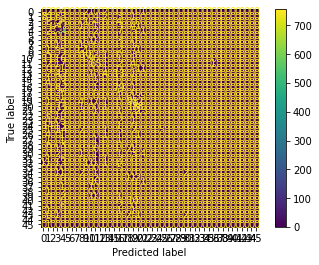

In [ ]:
cm = confusion_matrix(y_test_, y_pred)
disp = ConfusionMatrixDisplay(cm, )
disp.plot()

Tensorboard
-----------
not working 👎

In [ ]:
# %load_ext tensorboard

In [ ]:
# import datetime, os
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
# %%time
# history = model.fit(
#     x=x_train,
#     y=y_train,
#     epochs=10,
#     validation_data=(x_test, y_test),
#     callbacks=[tensorboard_callback],
#     verbose=1
# )

In [ ]:
# # %tensorboard --logdir logs
# from tensorboard import notebook
# notebook.list() # View open TensorBoard instances

# # Control TensorBoard display. If no port is provided, 
# # the most recently launched TensorBoard is used
# notebook.display(port=6006, height=1000)

**A better approach**
Let's try with a bit more pre-processing
 - reduce MAXLEN to 512
 - remove most common words and least common words

In [ ]:
from collections import defaultdict
index_freq = defaultdict(int)
max_index_in_wordmap = max(index_word.keys())
for sent in x_train:
  for index in sent:
    # for some reason, a couple of indexes are not available in word_index map
    if index > max_index_in_wordmap:
      continue
    else:
      index_freq[index] += 1

index_freq = [(index, freq) for index, freq in index_freq.items()]
index_freq.sort(key=lambda x:x[1], reverse=True)
index_freq[:2]

[(0, 7677835), (4, 65915)]

In [ ]:
word_freq = [(index_word[tup[0]], tup[1]) if tup[0] != 0 else ("Unknown", tup[1]) for tup in index_freq ]

In [ ]:
# word_freq[-25:]
once_occuring = len([word for (word, count) in index_freq if count == 1])
once_occuring

9420

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.reuters.load_data(skip_top=100, num_words=512)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((8982,), (2246,), (8982,), (2246,))

In [ ]:
plot_lenghts(x_train)